# Light Pollution Analysis - Boulder, CO 
`Author: John Salisbury / Last Updated: Apr 9, 2023`
***

<div style="max-width:1000px; min-width: 300px; width: 100%; margin: auto">
<img src="https://john-salisbury.github.io/light-pollution-analysis/data/output/lp_map.png" width="100%"/>
<p style="text-align: center; font-size: 12px;">An interactive map of $\Delta$ radiance $(nW·sr^{-1}/cm^2)$ in Boulder, CO between 2012-2021. Read on to learn more!</p>
</div>

***

## Summary
This brief analysis **explores how light pollution has changed in the city of Boulder, Colorado** over the past decade or so. 

I am an avid astrophotographer and love to take photos of the stars, especially in the foothills above my beautiful hometown of Boulder, CO. Sadly, however, light pollution from the city seems to have made this activity exceedlingly difficult in the past decade. After trying to take some timelapses that were ruined by bright city lights on a recent late-night trip, I became curious — **has light pollution from Boulder become worse in recent years, and if so, are there certain areas of the city that produce more light pollution than others?** So, I thought that it would be interesting to take a look at how light pollution in my hometown has changed in the past decade. 

To explore this topic, **I processed, visualized, and summarized 10 years of nighttime radiance data** collected from NASA's [Visible Infrared Imaging Radiometer Suite (VIIRS)](https://www.earthdata.nasa.gov/learn/find-data/near-real-time/viirs) instrument aboard the NASA/NOAA Joint Polar Satellite System (more specifically, NASA's *VIIRS/NPP Lunar BRDF-Adjusted Nighttime Lights Yearly Composites* product for 2012-2021). This is the same radiance data which powers the popular [lightpollutionmap.info](https://lightpollutionmap.info) web application that allows users to visualize sources of light pollution across the globe.

The data provides annual composite estimates of radiance — the flux of radiation emitted per unit solid angle in a given direction by a unit area of a source — in a rasterized format at a spatial resolution of roughly $500m$. Although it's not a direct measure of sky quality (i.e., darkness), **radiance is a useful way to measure light pollution** and allows us to assess how light pollution has changed in the city of Boulder over the past decade or so.

**In the analysis below, I seek answers to the following questions:**
- How has radiance in Boulder, CO changed in the past decade?
- Where within the city is radiance the highest?
- Is it possible to compile some key recommendations for mitigation of nighttime radiance and light pollution within the city?

Let's get started!

--

*Table of Contents:*
<br>
<a href="#modules-data" class="toc">Import Modules and Data</a>
<br>
<a href="#process-data" class="toc">Process Spatial Data</a>
<br>
<a href="#explore-data" class="toc">Explore Data</a>
<br>
<a href="#radiance-changes" class="toc nest-one">Changes in Radiance (2012-2021)</a>
<br>
<a href="#recent-status" class="toc nest-one">Recent Status (2021)</a>
<br>
<a href="#insights" class="toc">Insights</a>

--

*Find the data for this project below:*
- [NASA VIIRS data](https://www.lightpollutionmap.info/help.html)
- [VIIRS documentation](https://viirsland.gsfc.nasa.gov/PDF/BlackMarbleUserGuide_v1.2_20210421.pdf)
- [City of Boulder spatial extent](https://data-boulder.opendata.arcgis.com/datasets/955e7a0f52474b60a9866950daf10acb)
*Note that all TIFs are stored externally and haven't been uploaded to the repository for this project.*

<div id="modules-data"></div>

***
## Import Modules and Data

### Modules
To start our analysis, we first **import a number of Python modules** that can be used to handle our raster data (i.e., the NASA VIIRS radiance data in GeoTIFF format that we'll use to assess light pollution), vector spatial data (i.e., a set of polygons that define Boulder city limits), and interactive mapping functionality. We also import standard Python modules to deal with dataframe operations and plotting.

In [1]:
#IMPORT MODULES ------

#Rasterio
import rasterio as rs   #Used to handle/process radiance data GeoTIFFs
from rasterio import mask   #Used to mask raster data based on a shapefile
from rasterio.plot import show   #Used to generate colorbars in plots

#Geopandas - used to mask raster data with shapefile
import geopandas as gp   #Used to mask raster data with shapefile

#Folium/EarthPy/Branca
import branca   #Used to generate colormaps that are compatible w/ Folium
import earthpy.spatial as es   #Used to bytescale raster data (for plotting w/ Folium)
import folium   #Used to generate and display Leaflet maps

#Other common modules
import matplotlib.cm
import matplotlib.pyplot as plt   #Plotting
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap   #Used to handle uneven scales/colorbars in plots
import numpy as np   #Array support
import os   #Used to navigate file structure
import pandas as pd   #DataFrame support

#IPython - HTML notebook formatting
from IPython.core.display import HTML

We'll add some custom CSS to improve the look and feel of our notebook:

In [60]:
#Add custom CSS to center output PNGs
HTML("""
<style>
.jp-needs-light-background {
    display: block;
    margin: auto;
}

.toc {
    font-size: 16px;
}

.nest-one {
    margin-left: 1em;
    font-style: italic;
    font-size: 14px;
}

.nest-two {
    margin-left: 3em;
    font-style: italic;
    font-size: 12px;
}

.faint {
    opacity: 0.2;
}

</style>
""")

<hr class="faint">

### Data
Next, we **round up the data** we'll be using. We create a list containing the GeoTIFF files available through NASA's VIIRS product that we'll use to assess light pollution within Boulder city limits. Each file represents rasterized observations of *average annual radiance* ($nW·sr^{-1}/cm^2$) across the entire world at a spatial resolution of roughly $500 m$ per observation. Thus, we end up with 10 GeoTIFF files, each containing radiance data for a specific year between 2012-2021.

In [3]:
#IMPORT DATA ------

#Create list of VIIRS GeoTIFF files to iterate through
rel_path = '../data/viirs_data'
files = os.listdir(rel_path)
files.sort()

#Drop any files that don't end in 'tif' (i.e., hidden files)
files = [file for file in files if 'tif' in file]

We can also go ahead and check the Coordinate Reference System (CRS) for our dataset below:

In [4]:
#Check CRS
crs_check = rs.open(rel_path + '/' + files[0])
print('Coordinate Reference System: ' + str(crs_check.crs))

Coordinate Reference System: EPSG:4326


We see that our GeoTIFF files use the *EPSG 4326 coordinate reference system*, which is roughly equivalent to the commonly used WGS84 CRS.

<div id="process-data"></div>

***
## Process Spatial Data

### Import Vector Data to Mask GeoTIFF Files
The next step in the process is to **prepare to iterate over and process each of the GeoTIFF files** we have. As described in our intro, we're only interested in assessing light pollution (i.e., radiance) *within* the city of Boulder, CO. This means that we need to filter out, or "mask", any data that does not fall within Boulder city limits.

To accomplish this, we import `shapefile`, a shapefile downloaded from the City of Boulder's municipal GIS platform which contains coordinates for a series of polygons that collectively represent Boulder city limits. We'll use these polygons to crop our files into a much narrower view (which will greatly speed up processing time), as well as filter out all radiance data that does not lie within the city of Boulder. This process is called "masking".

Before using this shapefile, we should go ahead and confirm that the CRS for shapefile matches that of our GeoTIFF data:

In [5]:
#Import shapefile of Boulder, CO city boundaries using geopandas
shapefile = gp.read_file("../data/boulder_shapefile/City_of_Boulder_City_Limits.shp")

#Isolate geometry of each feature in shapefile, which will be passed to 
#rasterio's mask function
shapes = shapefile["geometry"]

#Confirm that shapefile is on same CRS (ESPG 4326)
print("Coordinate Reference System: " + str(shapefile.crs))

Coordinate Reference System: EPSG:4326


Because our GeoTIFF files are also in the EPSG 4326/WGS84 coordinate reference system, we do not need to reproject any of our data into a different CRS before moving forward.

<hr class="faint">

### Process GeoTIFF Files
Now, we are ready to **iterate over and process each of our GeoTIFF files**. We define a simple function (`iter_func`) that handles the nitty-gritty details of GeoTIFF processing. The function accepts (1) a GeoTIFF file and (2) geometry for a shapefile feature collection. In return, it does the following:
- Crops and masks the GeoTIFF file based on the geometry of the shapefile
- Saves the masked version of that file as a Numpy array (for later plotting and array calculations)
- Calculates summary statistics for all array values in the masked version of the file

In [6]:
def iter_func(file, shapes):
        
        #Create placeholder dictionary that will contain data for given year
        year_data = {}
        
        #(A) Grab year from filename ----------
        year_data["year"] = file.split("/")[-1].split("_")[1]
        
        #(B) Open GeoTIFF file ----------
        
        #Import file with rasterio
        src = rs.open('../data/viirs_data/' + file)
        
        #(C) Create a mask around Boulder city limits using shapefile (and crop) ----------

        #Generate np array (out_image) and affine transformation
        #matrix (out_transform) using rasterio's mask function
        out_image, out_transform = rs.mask.mask(src, shapes, nodata=-1, crop=True)
    
        #Remove third dimension in array so that 'out_image' is a 2D array
        out_image = np.squeeze(out_image)
    
        #Replace all negative values with nan (to allow for mean/min/max calcs)
        out_image = np.where(out_image<0, np.nan, out_image)
    
        #Assign metadata from GeoTIFF to variable
        out_meta = src.meta
    
        #Update metadata
        out_meta.update({"driver": "GTiff",
                         "height": out_image.shape[0],
                         "width": out_image.shape[1],
                         "transform": out_transform})
        
        #(D) Add masked image (and meta) to year_data dict ----------
        year_data["array"] = out_image
        year_data["array_meta"] = out_meta
        
        #(E) Calculate summary statistics and save to placeholder dict ----------
        dt = [[year_data["year"], np.nanmax(out_image), np.nanmin(out_image),
             np.nanmean(out_image), np.nanmedian(out_image), np.nanstd(out_image)]
             ]
        year_data["stats"] = pd.DataFrame(dt, columns=["year","max","min","mean","median","sd"])
        
        return year_data

Next, we use a list comprehension to apply this function to each of our files. The result of this operation is the list `rads`, which contains a dictionary of the following items for each year between 2012-2021:
- `year` - the corresponding year of radiance data
- `array` - the masked, cropped GeoTIFF saved as a Numpy array
- `array_meta` - a dictionary of metadata for `array`
- `stats` - summary statistics for the radiance values in `array`

In [7]:
#Use list comprehension to apply the function above to each file
rads = [iter_func(file, shapes) for file in files]

After this step, we have everything we need to explore and visualize our data! 

<div id="explore-data"></div>

***
## Explore Data

<div id="radiance-changes"></div>

### Changes in Radiance (2012-2021)

#### Mean, Maximum, and Minimum Radiance
*Figure 1* below shows **average, maximum, and minimum average annual radiance ($nW·sr^{-1}/cm^2$)** within the city of Boulder, CO between 2012-2021. Average radiance is calculated by averaging all 500m pixels within Boulder city limits for a given year, whereas maximum and minimum radiance are calculated by taking the highest and lowest values within city limits, respectively.

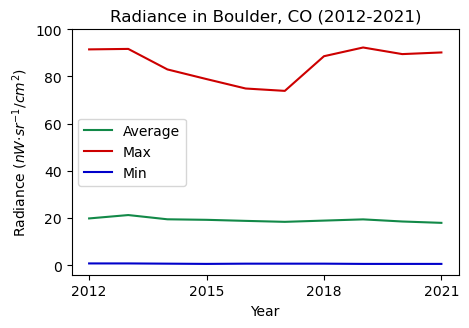

In [8]:
#(A) Concatenate "stats" from each year into unified dataframe that can be used for plotting
stats = [yr["stats"] for yr in rads]
stat_df = pd.concat(stats, axis=0)

#(B) Save radiance title and label as string for future plotting/labeling ---------
rad_title = "Radiance in Boulder, CO (2012-2021)"
rad_lab = r"Radiance ($nW·sr^{-1}/cm^2$)"

#(C) Plot of mean, max, and min ---------
plt.figure(figsize=(5,3.25), dpi=100)
plt.plot(stat_df["year"], stat_df["mean"], label="Average", color="#128948")
plt.plot(stat_df["year"], stat_df["max"], label="Max", color="#cd0000")
plt.plot(stat_df["year"], stat_df["min"], label="Min", color="#0000ca")
plt.title(rad_title, fontsize=12)
plt.xlabel("Year")
plt.xticks(["2012", "2015", "2018", "2021"])
plt.ylabel(rad_lab)
plt.yticks([0,20,40,60,80,100])
plt.legend(loc="center left")
plt.show()

<p style="text-align: center; font-size: 12px; max-width: 800px; margin: auto"><b>Figure 1</b>. Average, maximum, and minimum composite annual radiance (nW·sr<sup>-1</sup>/cm<sup>2</sup>) within the city of Boulder, CO between 2012-2021.</p>
<br><br>

We can see that both average and minimum radiance within city limits were relatively constant during this time period. Minimum radiance remained close to 0 $nW·sr^{-1}/cm^2$ throughout the time period, indicating that essentially no light was emitted in at least one 500m "pixel" contained within Boulder city limits between 2012-2021, whereas average radiance remained close to 20 $nW·sr^{-1}/cm^2$. Note that, for visualization purposes, we did not plot standard deviation around the mean or any other measurement of spread within the data.

In contrast, maximum radiance — i.e., the radiance value of the "brightest" 500m pixel in the dataset — was substantially higher and more variable throughout the time period than average radiance. Maximum radiance within the city declined between 2013-2017 but appears to have increased to over 90 $nW·sr^{-1}/cm^2$ between 2017-2021. For reference, this radiance value is on par with that of areas like [Brooklyn](https://www.lightpollutionmap.info/#zoom=12.01&lat=40.7127&lon=-73.9506&state=eyJiYXNlbWFwIjoiTGF5ZXJCaW5nUm9hZCIsIm92ZXJsYXkiOiJ2aWlyc18yMDIxIiwib3ZlcmxheWNvbG9yIjpmYWxzZSwib3ZlcmxheW9wYWNpdHkiOjYwLCJmZWF0dXJlc29wYWNpdHkiOjg1fQ==) and [San Francisco](https://www.lightpollutionmap.info/#zoom=10.00&lat=37.7749&lon=-122.4194&state=eyJiYXNlbWFwIjoiTGF5ZXJCaW5nUm9hZCIsIm92ZXJsYXkiOiJ2aWlyc18yMDIxIiwib3ZlcmxheWNvbG9yIjpmYWxzZSwib3ZlcmxheW9wYWNpdHkiOjYwLCJmZWF0dXJlc29wYWNpdHkiOjg1fQ==).

<hr class="faint">

#### Spatial Changes in Radiance
Although the city-wide summary statistics above might be useful, it seems likely that light pollution throughout the city of Boulder is probably highly spatially heterogenous. Thus, it could be interesting to explore how radiance within city limits over time using *spatial plots*.

In *Figure 2* below, we have generated these plots, each of which shows **average annual radiance ($nW·sr^{-1}/cm^2$)** within Boulder, CO **in a grid format** at a spatial resolution of $500m$ for the years 2012, 2015, 2018, and 2021.

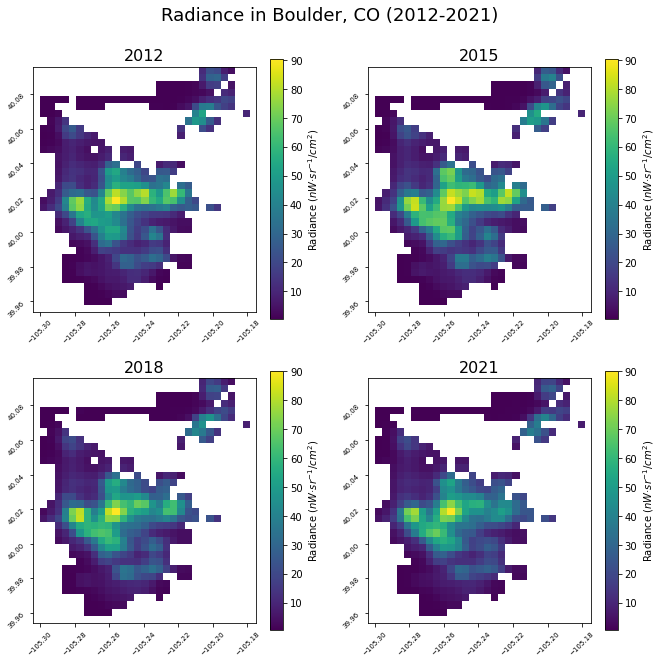

In [9]:
#(A) 2x2 Plot for 2012, 2015, 2018, and 2021 ---------

#Create a list with years of interest
yr_list = [2012,2015,2018,2021]

#Define an affine transformation matrix to use for our subplots
out_transform = rads[0]["array_meta"]["transform"]

#Generate plot
fig, axs = plt.subplots(2,2, figsize=(11,10.5))

#Base plots for color bars
base1 = plt.imshow(rads[-1]["array"])

#Generate subplots
for yr, ax in zip(yr_list, axs.flatten()):
    show(rads[yr-2012]["array"], ax=ax, transform=out_transform)
    fig.colorbar(base1, ax=ax, label=rad_lab)
    plt.setp(ax.get_xticklabels(), fontsize=7, rotation=45)
    plt.setp(ax.get_yticklabels(), fontsize=7, rotation=45)
    ax.set_title(yr, fontsize=16)

#Add plot title
plt.suptitle(rad_title, fontsize=18, y=0.95)
plt.show()

<p style="text-align: center; font-size: 12px; max-width: 800px; margin: auto"><b>Figure 2</b>. Average annual radiance (nW·sr<sup>-1</sup>/cm<sup>2</sup>) within the city of Boulder, CO in 2012, 2015, 2018, and 2021. Each pixel represents a 500m x 500m area.</p>
<br><br>

We can see that the highest radiance observations (in all years) are generally located near the center of the city limits, as well as along an east-west axis running through the center of the city. However, it is difficult to identify spatial changes in radiance from year to year in *Figure 2*.

To **better identify spatial changes in radiance over time**, we can generate plots that show *changes in radiance* (using values from 2012 as a baseline), rather than plots of just radiance. In *Figure 3* below, red pixels indicate an *increase* in radiance relative to 2012 values (i.e., the first year that we have radiance data for), whereas blue pixels indicate a *decrease* in radiance. 

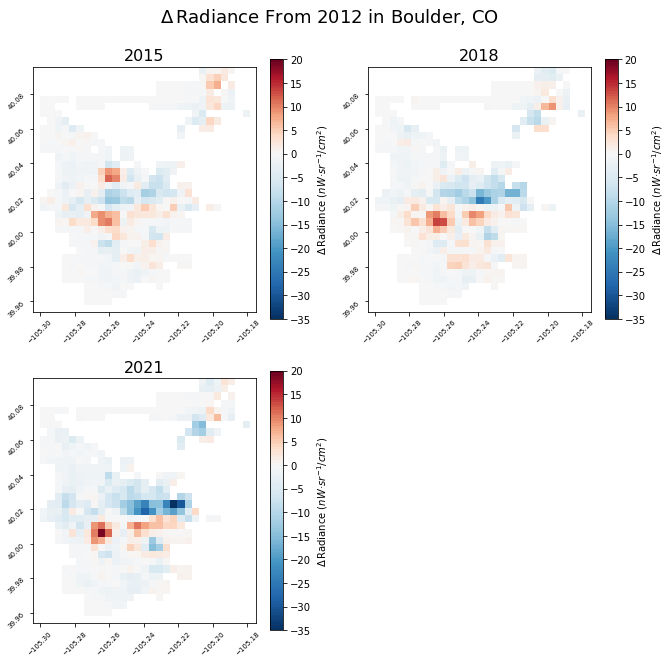

In [10]:
#(A) Array calculations for delta plots ---------

#Calculate delta radiance after 3 years, 6 years, and 9 years (using 2012 as a baseline)
deltas = [rads[yr-2012]["array"] - rads[0]["array"] for yr in yr_list[-3:]]

#Generate two-slope norm (based on delta_9, which has greatest range)
norm = TwoSlopeNorm(vmin=-35, vcenter=0, vmax=20)

#(B) Generate plot ---------

#Define colormap
colmap = "RdBu_r"

#Generate faceted plot
fig, axs = plt.subplots(2,2, figsize=(11,10.5))

#Base plot for color bars
base2 = plt.imshow(deltas[-1], cmap=colmap, norm=norm)

#Generate subplots
ticks=list(np.linspace(-35,20,12))
for dlt, yr, ax in zip(deltas, yr_list[-3:], axs.flatten()):
    show(dlt, ax=ax, transform=out_transform, cmap=colmap, norm=norm)
    fig.colorbar(base2, ax=ax, label=r"$\Delta\/$" + rad_lab, spacing='uniform', boundaries = np.linspace(-35, 20, 100), ticks=ticks)
    plt.setp(ax.get_xticklabels(), fontsize=7, rotation=45)
    plt.setp(ax.get_yticklabels(), fontsize=7, rotation=45)
    ax.set_title(yr, fontsize=16)

#Hide missing subplot but keep 2x2 formatting
axs.flatten()[3].set_visible(False)

#Add plot title
plt.suptitle(r"$\Delta\/$" + "Radiance From 2012 in Boulder, CO", fontsize=18, y=0.95)
plt.show()

<p style="text-align: center; font-size: 12px; max-width: 800px; margin: auto"><b>Figure 3</b>. Difference in average annual radiance (nW·sr<sup>-1</sup>/cm<sup>2</sup>) within the city of Boulder, CO relative to 2012 values. Each pixel represents a 500m x 500m area.</p>
<br><br>

In 2015, we see relatively little change in radiance across the city relative to 2012. Radiance in certain areas near the city center appears to increase by a magnitude of roughly 10-15 $nW·sr^{-1}/cm^2$, whereas radiance in small pockets throughout the city limits seem to decrease slightly. We also see relatively little change in radiance in the northwestern and southern regions of the city (areas that are predominantly residential neighborhoods with few commercial lots).

By 2021, however, we see more pronounced changes in radiance within several areas of the city. The largest increase in radiance seems to be located in a spot near the city center, with a change from 2012 values roughly 20 $nW·sr^{-1}/cm^2$ in magnitude. In contrast, radiance within a wide swath of eastern Boulder appears to have decreased by up to 30-35 $nW·sr^{-1}/cm^2$ in some places. Similar to previous years, we see relatively little change in radiance among northwestern and southern neighborhoods.

By exploring this data spatially, we see that the trend in average radiance values that we plotted in *Figure 1* is more complicated than we initially thought. Radiance seems to have increased in some pockets of the city and decreased in others, ultimately producing a relatively consistent city-wide average between 2012-2021.

<hr class="faint">

#### Identifying Hotspots for Change
By overlaying our raster plot of changes in radiance since 2012 on to a map of Boulder, we can **get a better sense of how radiance has changed within specific neighborhoods of the city**. In *Figure 4* below, we use the module `folium` to (1) generate an interactive base map of Boulder and (2) overlay observed changes in radiance from 2012 after 9 years (i.e., radiance data from 2019) on to that map. 

Similar to our plots above, red pixels indicate an *increase* in radiance relative to 2012 values, whereas blue pixels indicate a *decrease* in radiance. Location markers indicate areas in which radiance seems to have changed (either increased *or* decreased) the most since 2012. Additionally, the blue outline represents the spatial extent of Boulder city limits.

In [63]:
#(A) Prepare delta 2021 raster data for mapping with folium module ---------

#Replace NaN values in delta_9 array with 0 (done to facilitate plotting with folium)
delta_9_plot = np.nan_to_num(deltas[-1], nan=0)

#Create new GeoTIFF file - this will allow us to extract bounds of file without having to worry about another
#affine transformation
plot_arr = rs.open('../data/output/delta9.tif', 'w', driver='GTiff',
                            height = delta_9_plot.shape[0], width = delta_9_plot.shape[1],
                            count=1, dtype=str(delta_9_plot.dtype),
                            crs=str(rads[0]["array_meta"]["crs"]),
                            transform=rads[0]["array_meta"]["transform"])

plot_arr.write(delta_9_plot, 1)
plot_arr.close()

#Reopen newly saved GeoTIFF file
plot_arr = rs.open('../data/output/delta9.tif')

#Read first band in GeoTIFF - this is what we will overlay on the folium map
arr = plot_arr.read(1)


#(B) Generate map using folium module ---------

#Generate base map centered on Boulder, CO
m1 = folium.Map(location=[40.0150, -105.2405],
               tiles = 'Stamen Terrain',
               zoom_start = 13,
               max_zoom = 16,
               min_zoom = 12)

#Generate map bounds from newly imported GeoTIFF file of 2021 raster data
map_bounds = [[plot_arr.bounds[1],plot_arr.bounds[0]],[plot_arr.bounds[3],plot_arr.bounds[2]]]

#Define custom colormap for map
colormap = branca.colormap.LinearColormap(colors=["#00004c","#ffffff","#922626"],
                                          vmin=-30, vmax=20, index=[-35,0,20],
                                          tick_labels=ticks)

colormap.caption = "Difference in Radiance (nW·sr-1/cm2) - 2012-2021"


#(C) Overlay delta 2021 raster data on base map ---------

#Add raster data
m1.add_child(folium.raster_layers.ImageOverlay(arr,
                                              bounds=map_bounds,
                                              opacity=0.75,
                                              colormap=colormap.rgba_floats_tuple,
                                              ))


#(D) Overlay shapefile of Boulder city limits on base map ---------

#Define a style function to pass to folium's GeoJSON function
style_func = lambda x: {
    "fillColor": "#ffffff",
    "fillOpacity": 0,
    "opacity":0.4,
}

#Add polygons
m1.add_child(folium.GeoJson(shapes, style_function=style_func))


#(E) Add location markers for areas with high degree of change ---------

#Import location marker data
locs = pd.read_csv("../data/boulder_locs/loc_marker_coords.csv")

#Define function to create folium location markers from df
def loc_func(x):
    marker = folium.Marker(
        [x['lat'],x['lon']],
        tooltip=x['loc_name'],
        icon=folium.map.Icon(color=x['color'], icon_color="white", icon="circle-notch", prefix="fa")
    )
    return marker

#Apply function across all rows of location marker df
markers = locs.apply(loc_func, axis=1)

#Add "blue" markers to map only
for mk in markers[:len(locs[locs["color"] == "blue"])]:
    mk.add_to(m1)

#Add colorbar with branca module
colormap.add_to(m1)

#Display map
m1

<p style="text-align: center; font-size: 12px; max-width: 800px; margin: auto"><b>Figure 4</b>. Map of difference in average annual radiance (nW·sr<sup>-1</sup>/cm<sup>2</sup>) within the city of Boulder, CO between 2012 and 2021. Each pixel represents a 500m x 500m area. Blue outlines represent Boulder city limits.</p>
<br><br>

As you can likely see, there is a noticeable mismatch between the polygon representing Boulder city limits and our raster data. Unfortunately, this is a byproduct of the masking process, which retains or drops pixels near the edge of the polygon based on the proportion of the pixel that is contained within it.

In *Figure 4*, we can identify a number of locations at which radiance seems to have changed substantially between 2012-2021 (*hover on each location marker to view location name*):
- **CU Boulder - Central Campus**: CU Boulder's main campus seems to be the location at which radiance has increased the most within Boulder city limits (increasing by nearly 20 $nW·sr^{-1}/cm^2$). This makes sense, as the university constructed a number of large, new buildings on its campus during this time period.

- **Pearl Office Park**: surprisingly, radiance in this office park (which consists entirely of large commercial properties) appears to have decreased sharply since 2012.

- **Flatirons Office Park**: similar to Pearl Office Park, we see a relatively sharp decrease in radiance within the Flatirons Office Park of central eastern Boulder.

It is important to take the decreases in radiance we see above with a grain of salt. Did radiance actaully decrease within these heavily developed office parks between 2009-2021? Or, are property-wide changes in exterior lighting (e.g., a change from high pressure sodium lamps to high color temperature LEDs, which VIIRS is [less sensitive to](https://agupubs.onlinelibrary.wiley.com/doi/pdf/10.1002/2013JD020475)) responsible for observed decreases? Further investigation outside the scope of this project is necessary.

<hr class="faint">

<div id="recent-status"></div>

### Recent Status (2021)
Above, we've seen that radiance at certain locations within the city of Boulder changed by up to 35 $nW·sr^{-1}/cm^2$ between 2012-2021. However, we still don't have a great sense of what locations within the city currently have the *highest radiance* - i.e., which locations are producing the worst light pollution as of 2021.

In *Figure 5* below, we have overlaid radiance data for 2021 on to our existing basemap, with city limits outlined in blue. Dark pixels indicate relatively low radiance values, whereas light pixels indicate relatively high values. Blue location markers indicate the locations from our previous map in which we observed a substantial *change* in radiance between 2012-2021, whereas green location markers indicate newly identified areas in which radiance seems to be high.

In [64]:
#(A) Prepare normal 2021 raster data for mapping with folium module ---------

#Replace NaN values in 2021 array with 0
yr_2021_plot = np.nan_to_num(rads[-1]["array"], nan=0)

#Scale to bytescale for plotting w/ Folium
scaled_img = es.bytescale(yr_2021_plot)

#(B) Generate map using folium module ---------

#Generate another base map centered on Boulder, CO
m2 = folium.Map(location=[40.0150, -105.2405],
               tiles = 'Stamen Terrain',
               zoom_start = 13,
               max_zoom = 16,
               min_zoom = 12)

#Define custom colormap and colorbar
cmap = matplotlib.cm.get_cmap('viridis', 5)    # PiYG
cmap_hex = [matplotlib.colors.rgb2hex(cmap(i)) for i in range(cmap.N)]
colormap2 = branca.colormap.LinearColormap(cmap_hex, vmin=0, vmax=np.nanmax(yr_2021_plot))
colormap2.caption = "Average Annual Radiance (nW·sr-1/cm2) - 2021"

#(C) Overlay 2021 raster data on base map ---------

#Overlay array on base map
m2.add_child(folium.raster_layers.ImageOverlay(scaled_img,
                                              bounds=map_bounds,
                                              opacity=0.7,
                                              colormap=matplotlib.cm.viridis
                                              ))

#(D) Overlay shapefile of Boulder city limits on base map ---------

#Add polygons
m2.add_child(folium.GeoJson(shapes, style_function=style_func))

#(E) Add additional location markers ---------

#Add all markers to map
for mk in markers:
    mk.add_to(m2)

#(F) Add colorbar ---------
colormap2.add_to(m2)

#Display map
m2

<p style="text-align: center; font-size: 12px; max-width: 800px; margin: auto"><b>Figure 5</b>. Map of average annual radiance (nW·sr<sup>-1</sup>/cm<sup>2</sup>) within the city of Boulder, CO in 2021. Each pixel represents a 500m x 500m area. Blue outlines represent Boulder city limits.</p>
<br><br>

We can now identify several new locations in which radiance seems to be much higher than the 2021 average value of roughly 20 $nW·sr^{-1}/cm^2$ — three of which are shopping districts (i.e., Pearl Street Mall, 29th Street Mall, and Diagonal Plaza Shops), and two of which are office parks (i.e., Spine Road Office Park and IBM's Office Park).

We can also see that a few of the locations we had previously identified as having experienced substantial changes in radiance between 2012-2021 also have higher radiance than average. For example, we see that pixels centered around CU Boulder's main campus are roughly 20-40 $nW·sr^{-1}/cm^2$ higher than our 2021 average of 20 $nW·sr^{-1}/cm^2$. 

<div id="insights"></div>

***
## Insights

#### How has radiance in Boulder, CO changed in the past decade?
> Average radiance across the city did not appear to increase between 2012-2021 (*Figure 1*). However, radiance within certain areas of Boulder — most notably, CU Boulder's main campus — increased by nearly 20 $nW·sr^{-1}/cm^2$ during this time period, whereas radiance in other areas — such as office parks in eastern Boulder — seems to have decreased by a similar magnitude. Thus, it is difficult to make generalizations to the entire city, as changes in radiance between 2012-2021 appear to be spatially heterogeneous. Some areas are getting brighter and others are getting darker, but radiance in most of the city does not appear to have changed much since 2012.

#### Where within the city is radiance the highest?
> Three distinct areas stand out as the worst offenders. As of 2021, pixels centered around *29th Street Mall*, *Pearl Street Mall*, and *CU Boulder's main campus* had radiance that was much higher than Boulder's 2021 average, with maximum values of 89.5, 78.0, and 57.0 $nW·sr^{-1}/cm^2$ respectively (*Figure 5*). Additionally, radiance in office parks and commercial complexes in eastern and northeastern Boulder also appeared to be above average. 

#### Recommendations
> Radiance (and light pollution) is substantially higher in several of Boulder's key commercial areas than elsewhere in the city. The City of Boulder should prioritize these locations when planning any light pollution mitigation actions.

> Additionally, CU Boulder's main campus is one of the worst sources of light pollution in the city. The City of Boulder should engage with the university to explore how light fixture shielding and other dark sky solutions could implemented across its various campus buildings.